## Perturbation analysis

Here we use the trained model to analyze the importance of each position and each amino acid in the sequence.

In [1]:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

/mnt/8t/jjr/Structural-DPP-IV


In [2]:
class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)

    def forward(self, x):
        TextCNN_Only = False
        StructuralEncodingOnly = False
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(x[0])
            StructedEncode = self.StructEncodeModule(x[1])
            newEncode = TextCNNEncode * StructedEncode
            output = self.classification(newEncode)
            return output, newEncode
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(x[0])
            output = self.classification(TextCNNEncode)
            return output, TextCNNEncode
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x[1])
            output = self.classification(StructedEncode)
            return output, StructedEncode


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature

In [6]:
def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    # print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)

In [7]:
def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)

    # sequence_data = sequence_data_process.cuda()
    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]

In [8]:
def load_tsv(filename, skip_head=True):
    sequences = []
    labels = []
    with open(filename, 'r') as file:
        if skip_head:
            next(file)
        for line in file:
            if line[-1] == '\n':
                line = line[:-1]
            list = line.split('\t')
            sequences.append(list[2])
            labels.append(int(list[1]))
    return sequences, labels

In [9]:
new_model = StructuralDPPIV(args).cuda()
load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')

[INFO] using Structural config of DPP-IV
[INFO] using CNN config of DPP-IV


In [12]:
new_model.eval()
DATA = get_one_sequence_code('NYIVPEDKREMWMACIAELH')
output, embedding = new_model(DATA)
pred_prob_all = F.softmax(output, dim=1)  # predict probability [batch_size, class_num]
pred_prob_all

tensor([[0.9917, 0.0083]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [17]:
pred_prob = []
label_pred = []
predict_true = 0

sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
from tqdm import tqdm
# predict sequence one by one
for index in tqdm(range(len(sequences))):
    # print("before success2:", config.learn_name)
    sequence_code = get_one_sequence_code(sequences[index])
    logits, representation = new_model(sequence_code)

    pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
    pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
    pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
    pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

    pred_prob = pred_prob + pred_prob_positive.tolist()
    label_pred = label_pred + pred_class.tolist()

acc = accuracy_score(labels, label_pred)
auc = roc_auc_score(labels, pred_prob)
f1 = f1_score(labels, label_pred)
se = recall_score(labels, label_pred)
sp = recall_score(labels, label_pred, pos_label=0)

print('acc:', acc)
print('auc:', auc)
print('f1:', f1)
print('se:', se)
print('sp:', sp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:06<00:00, 39.04it/s]

acc: 0.8947368421052632
auc: 0.9625190796540222
f1: 0.8978102189781022
se: 0.924812030075188
sp: 0.8646616541353384


# Perturbation analysis

In [14]:
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
           'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17,
           'W': 18, 'Y': 19, 'V': 20}
aa_list = list(aa_dict.keys())

In [15]:
import copy
def perturbation_process():
    sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')

    save_data_abs = []
    save_data_normal = []
    iter_sequences = sequences

    for k in tqdm(range(len(iter_sequences))):
        iter_sequence_origin = iter_sequences[k]
        iter_sequence_len = len(iter_sequence_origin)
        result_matrix_abs = np.zeros((len(aa_list), len(iter_sequence_origin)))
        result_matrix_normal = np.zeros((len(aa_list), len(iter_sequence_origin)))

        sequence_code_origin = get_one_sequence_code(iter_sequence_origin)
        with torch.no_grad():
            output, feature = new_model(sequence_code_origin)
        output = torch.softmax(output, dim=1)[0][1].item()

        for i in range(0, iter_sequence_len):
            for j in range(len(aa_list)):
                iter_sequence_perturbation = copy.copy(iter_sequence_origin)
                iter_sequence_perturbation = iter_sequence_perturbation[:i] + aa_list[j] + iter_sequence_perturbation[i + 1:]
                sequence_code_perturbation = get_one_sequence_code(iter_sequence_perturbation)
                with torch.no_grad():
                    output_perturbation, feature = new_model(sequence_code_perturbation)
                output_perturbation = torch.softmax(output_perturbation, dim=1)[0][1].item()

                # 计算差异
                # diff = output_modification - output
                diff_abs = abs(output_perturbation - output)
                diff_normal = output_perturbation - output

                result_matrix_abs[j][i] = diff_abs
                result_matrix_normal[j][i] = diff_normal
        save_data_abs.append([result_matrix_abs, iter_sequence_origin])
        save_data_normal.append([result_matrix_normal, iter_sequence_origin])

    torch.save(save_data_abs, '/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/abs_test.pt')
    torch.save(save_data_normal, '/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/normal_test.pt')

In [ ]:
perturbation_process()

# 3.1 Position importance (distribution normalization)

In [10]:
perturbation_abs_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/abs_test.pt')
perturbation_normal_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/normal_test.pt')

In [11]:
cut_number = 25
sequences_position_value = [[] for i in range(cut_number)]
all_sequences = perturbation_abs_data_sequences
for sequence_data in all_sequences:
    matrix = sequence_data[0]
    result_matrix = matrix.sum(axis = 0)
    # matrix = matrix * -1
    # matrix = matrix.tolist()
    # print(result_matrix)
    sequence_position_value = [0 for i in range(cut_number)]
    if len(result_matrix) < cut_number:
        for i in range(len(sequence_position_value)):
            position = int(i / cut_number * len(result_matrix))
            if position == len(result_matrix):
                position = len(result_matrix) - 1
            # print(result_matrix[position].item())
            # print(position)
            sequence_position_value[i] += result_matrix[position].item()
    elif len(result_matrix) >= cut_number:
        for i in range(len(result_matrix)):
            position = int(i / len(result_matrix) * cut_number)
            if position == cut_number:
                position = cut_number - 1
            sequence_position_value[position] += result_matrix[i].item()


    for i in range(len(sequences_position_value)):
        sequences_position_value[i].append(sequence_position_value[i])

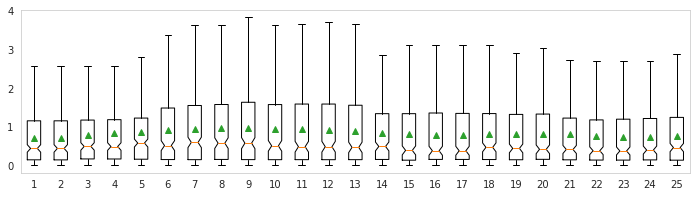

In [12]:
import matplotlib.pyplot as plt
def plot_box_now(data, keys):
    plt.figure(figsize=(12, 3))  # 画布
    ax=plt.axes()
    ax.grid(False)
    ax.boxplot(data,
                keys,  # 为箱线图添加标签，类似于图例的作用
                '',
               # sym="g+",  # 异常点形状，默认为蓝色的“+”
                showmeans=True  # 是否显示均值，默认不显示
                )

    plt.show()
plot_box_now(sequences_position_value, [i for i in range(cut_number)])

# 3.2 Position importance (not cut sequence)

In [13]:
# not cut sequence
sequences_position_origin_value = [0 for i in range(90)]
sequences_position_origin_count = [1 for i in range(90)]
for sequence_data in all_sequences:
    matrix = sequence_data[0]
    result_matrix = matrix.sum(axis = 0)

    for i in range(len(result_matrix)):
        sequences_position_origin_value[i] += result_matrix[i].item()
        sequences_position_origin_count[i] = sequences_position_origin_count[i] + 1

for i in range(len(sequences_position_origin_value)):
    sequences_position_origin_value[i] = sequences_position_origin_value[i] / sequences_position_origin_count[i]


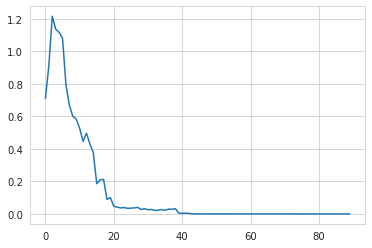

In [14]:
plt.plot(sequences_position_origin_value)

# 4. amino acid analysis
# 4.1. abs_data analysis on amino acid

In [21]:
perturbation_abs_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/abs_test.pt')
perturbation_normal_data_sequences = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/normal_test.pt')
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
           'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17,
           'W': 18, 'Y': 19, 'V': 20}
aa_list = list(aa_dict.keys())

In [18]:
abs_negative = perturbation_abs_data_sequences[labels.index(0):]
aa_value_each_negative_sequence = []
for sequence_data in abs_negative:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

abs_aa_value_origin_negative_sequence = np.array(aa_value_each_negative_sequence).sum(axis=0)
for i in range(len(abs_aa_value_origin_negative_sequence)):
    abs_aa_value_negative = (abs_aa_value_origin_negative_sequence - np.min(abs_aa_value_origin_negative_sequence)) / (
            np.max(abs_aa_value_origin_negative_sequence) - np.min(abs_aa_value_origin_negative_sequence))

In [22]:
abs_positive = perturbation_abs_data_sequences[:labels.index(0)]
aa_value_each_positive_sequence = []
for sequence_data in abs_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_positive_sequence.append(matrix)

abs_aa_value_origin_positive_sequence = np.array(aa_value_each_positive_sequence).sum(axis=0)
for i in range(len(abs_aa_value_origin_positive_sequence)):
    abs_aa_value_positive = (abs_aa_value_origin_positive_sequence - np.min(abs_aa_value_origin_positive_sequence)) / (
            np.max(abs_aa_value_origin_positive_sequence) - np.min(abs_aa_value_origin_positive_sequence))

In [23]:
count_aa_neg = [0 for i in range(20)]
count_aa_pos = [0 for i in range(20)]
for sequence in sequences[:labels.index(0)]:
    for aa in sequence:
        count_aa_pos[aa_dict[aa] - 1] += 1
for sequence in sequences[labels.index(0):]:
    for aa in sequence:
        count_aa_neg[aa_dict[aa] - 1] += 1
# print(count_aa_pos)
# print(count_aa_neg)
# sum(count_aa_pos)

In [24]:
abs_aa_value_origin_avg_positive_sequence = [0 for i in range(20)]
abs_aa_value_origin_avg_negative_sequence = [0 for i in range(20)]
for i in range(len(aa_list)):
    abs_aa_value_origin_avg_positive_sequence[i] = abs_aa_value_origin_avg_positive_sequence[i] / count_aa_pos[i]
    abs_aa_value_origin_avg_negative_sequence[i] = abs_aa_value_origin_avg_negative_sequence[i] / count_aa_neg[i]

In [25]:
for i in range(len(aa_list)):
    # print(aa_list[i],abs_aa_value_positive[i], abs_aa_value_negative[i])
    print(aa_list[i], abs_aa_value_origin_positive_sequence[i], abs_aa_value_origin_negative_sequence[i])
    print(aa_list[i], abs_aa_value_origin_avg_positive_sequence[i], abs_aa_value_origin_avg_negative_sequence[i])
    print("==================================")


A 37.28889890015125 51.39230017056252
A 0.0 0.0
R 67.55943594872952 69.65590276470175
R 0.0 0.0
N 37.621699035167694 53.16975567611371
N 0.0 0.0
D 35.37339295446873 52.69961123209214
D 0.0 0.0
C 39.75159692764282 49.61146239528898
C 0.0 0.0
Q 32.98174495995045 62.32208435684879
Q 0.0 0.0
E 40.3029819726944 59.483377323929744
E 0.0 0.0
G 41.238871455192566 54.67182070670242
G 0.0 0.0
H 50.0004627853632 55.391026240366045
H 0.0 0.0
I 40.47763633728027 53.85540417519951
I 0.0 0.0
L 30.723435133695602 51.600191354431445
L 0.0 0.0
K 45.093177780508995 55.92077710165904
K 0.0 0.0
M 34.404613107442856 59.737973216950195
M 0.0 0.0
F 39.416508972644806 53.85947550067067
F 0.0 0.0
P 31.215471148490906 68.3860094872216
P 0.0 0.0
S 36.773902893066406 49.514189100053045
S 0.0 0.0
T 38.774202436208725 55.42758255882654
T 0.0 0.0
W 60.59201896190643 67.749918850619
W 0.0 0.0
Y 61.33831927925348 65.0734813584786
Y 0.0 0.0
V 36.245572313666344 52.87843926771893
V 0.0 0.0


In [77]:
scores_abs_pos = {}
scores_abs_neg = {}
scores_abs_all_add = {}
scores_abs_all_sub = {}
for i in range(len(aa_list)):
    scores_abs_pos[aa_list[i]] = abs_aa_value_origin_avg_positive_sequence[i]
    scores_abs_neg[aa_list[i]] = abs_aa_value_origin_avg_negative_sequence[i]
    scores_abs_all_add[aa_list[i]] = abs_aa_value_origin_avg_positive_sequence[i] + abs_aa_value_origin_avg_negative_sequence[i]
    scores_abs_all_sub[aa_list[i]] = abs_aa_value_origin_avg_positive_sequence[i] - abs_aa_value_origin_avg_negative_sequence[i]

sorted(scores_abs_pos.items(), key=lambda x: x[1], reverse=True)

[('R', 0.09569325205202481),
 ('Y', 0.08688147206693128),
 ('W', 0.08582438946445671),
 ('H', 0.0708221852483898),
 ('K', 0.06387135662961614),
 ('G', 0.05841199922831808),
 ('I', 0.05733376251739415),
 ('E', 0.05708637673186175),
 ('C', 0.05630537808447992),
 ('F', 0.05583074925303797),
 ('T', 0.05492096662352511),
 ('N', 0.053288525545563306),
 ('A', 0.052817137252338886),
 ('S', 0.05208768115165213),
 ('V', 0.051339337554768195),
 ('D', 0.05010395602615967),
 ('M', 0.048731746611108864),
 ('Q', 0.04671635263449072),
 ('P', 0.04421454836896729),
 ('L', 0.04351761350381814)]

# 4.2. abs_data analysis on amino acid

In [26]:
normal_negative = perturbation_normal_data_sequences[labels.index(0):]
aa_value_each_negative_sequence = []
for sequence_data in normal_negative:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_negative_sequence.append(matrix)

normal_aa_value_origin_negative_sequence = np.array(aa_value_each_negative_sequence).sum(axis=0)
for i in range(len(normal_aa_value_origin_negative_sequence)):
    normal_aa_value_negative = (normal_aa_value_origin_negative_sequence - np.min(normal_aa_value_origin_negative_sequence)) / (
            np.max(normal_aa_value_origin_negative_sequence) - np.min(normal_aa_value_origin_negative_sequence))

In [27]:
normal_positive = perturbation_normal_data_sequences[:labels.index(0)]
aa_value_each_positive_sequence = []
for sequence_data in normal_positive:
    matrix = sequence_data[0]
    matrix = matrix.sum(axis = 1)
#     matrix = matrix * -1
    matrix = matrix.tolist()
    aa_value_each_positive_sequence.append(matrix)

normal_aa_value_origin_positive_sequence = np.array(aa_value_each_positive_sequence).sum(axis=0)
for i in range(len(normal_aa_value_origin_positive_sequence)):
    normal_aa_value_positive = (normal_aa_value_origin_positive_sequence - np.min(normal_aa_value_origin_positive_sequence)) / (
            np.max(normal_aa_value_origin_positive_sequence) - np.min(normal_aa_value_origin_positive_sequence))

In [28]:
normal_aa_value_origin_avg_positive_sequence = [0 for i in range(20)]
normal_aa_value_origin_avg_negative_sequence = [0 for i in range(20)]
for i in range(len(aa_list)):
    normal_aa_value_origin_avg_positive_sequence[i] = normal_aa_value_origin_positive_sequence[i] / count_aa_pos[i]
    normal_aa_value_origin_avg_negative_sequence[i] = normal_aa_value_origin_negative_sequence[i] / count_aa_neg[i]


In [29]:
for i in range(len(aa_list)):
    # print(aa_list[i],normal_aa_value_positive[i], normal_aa_value_negative[i], normal_aa_value_origin_positive_sequence[i], normal_aa_value_origin_negative_sequence[i])
    print(aa_list[i],normal_aa_value_origin_positive_sequence[i], normal_aa_value_origin_negative_sequence[i])
    print(aa_list[i],normal_aa_value_origin_avg_positive_sequence[i], normal_aa_value_origin_avg_negative_sequence[i])
    print("==================================")

A -10.61808954179287 1.8109338471185765
A -0.2869753930214289 0.010779368137610575
R -60.20052649080753 -34.6636873773823
R -2.508355270450314 -0.2962708322853188
N -13.307335764169693 -2.5158114519363153
N -0.5544723235070705 -0.03399745205319345
D -4.818351045250893 2.7573376438813284
D -0.22944528786909013 0.03322093546844974
C -25.47967156767845 -15.014921125082765
C -3.639953081096922 -0.18536939660596005
Q -8.51264674961567 29.80525851215498
Q -0.1979685290608295 0.39217445410730234
E -6.662897616624832 16.51188045753952
E -0.19596757695955389 0.14612283590742936
G -15.741430759429932 10.15349012929073
G -0.41424817787973506 0.06724165648536908
H -38.94452349841595 -24.355556799127953
H -1.854501118972188 -0.4510288296134806
I -20.47167694568634 -19.428900634251477
I -0.5532885660996308 -0.15061163282365486
L 6.794733792543411 20.406983352761017
L 0.09059645056724548 0.11795944134543941
K -31.606817081570625 -16.04841031801334
K -1.1288148957703794 -0.09609826537732538
M 16.84662

# 4.3. AAC (frequency of amid acid) analysis on amino acid

In [37]:
def read_sequence(path):
    positive_sequences = []
    negative_sequences = []

    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                line = line.split('\t')
                if line[1] == '1':
                    positive_sequences.append(line[2])
                else:
                    negative_sequences.append(line[2])
    return positive_sequences, negative_sequences


def AAC_frequency(data):
    frequency = {}
    frequency_list = []
    num = 0
    for i in data:
        seq = i
        for a in seq:
            if a in frequency.keys():
                frequency[a] += 1
            else:
                frequency[a] = 1
            num += 1

    name_list = aa_list
    output_list = {}
    all_f = 0
    for i, order in enumerate(name_list):
        frequency_list.append(frequency[order])
        output_list[order] = frequency[order] / num
        all_f += frequency[order] / num

    return output_list

positive_sequences, negative_sequences = read_sequence('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
AAC_frequency_positive = AAC_frequency(positive_sequences)
AAC_frequency_negative = AAC_frequency(negative_sequences)
AAC_frequency_all = AAC_frequency(sequences)
# print(AAC_frequency_negative)
# print(AAC_frequency_positive)

# 4.4. Comprehensive analysis on amino acid

In [31]:
scores_pos = {}
scores_neg = {}
scores_all = {}
for i in range(len(aa_list)):
    scores_pos[aa_list[i]] = normal_aa_value_origin_positive_sequence[i] / abs_aa_value_origin_positive_sequence[i]
    scores_neg[aa_list[i]] = normal_aa_value_origin_negative_sequence[i] / abs_aa_value_origin_negative_sequence[i]
    # scores_pos[aa_list[i]] = abs_aa_value_positive[i] * (normal_aa_value_positive[i] * normal_aa_value_positive[i])
    scores_all[aa_list[i]] = (normal_aa_value_origin_positive_sequence[i] + normal_aa_value_origin_negative_sequence[i]) / (abs_aa_value_origin_positive_sequence[i] + abs_aa_value_origin_negative_sequence[i])
    # print(aa_list[i], scores_neg[aa_list[i]], scores_pos[aa_list[i]])

In [33]:
aa_k_fold = {}
for i in range(len(aa_list)):
    aa_k_fold[aa_list[i]] = (AAC_frequency_positive[aa_list[i]] / AAC_frequency_negative[aa_list[i]] )
    # aa_k_fold[aa_list[i]] = (AAC_frequency_positive[aa_list[i]] / AAC_frequency_negative[aa_list[i]] ) * (AAC_frequency_positive[aa_list[i]] * AAC_frequency_negative[aa_list[i]])

# 5. heatmap on amino acid conversion

In [101]:
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G':    8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17,'W': 18, 'Y': 19, 'V': 20}
aa_list = list(aa_dict.keys())

# 5.1.2 A comprehensive analysis on training dataset

In [39]:
import copy
def perturbation_conversion_process(sequences = None):
    if sequences == None:
        sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')

    save_data_matrix_abs = [[0 for i in range(20)] for j in range(20)]
    save_data_matrix_normal = [[0 for i in range(20)] for j in range(20)]
    iter_sequences = sequences

    for k in tqdm(range(len(iter_sequences))):
        iter_sequence_origin = iter_sequences[k]
        iter_sequence_len = len(iter_sequence_origin)
        result_matrix_abs = np.zeros((len(aa_list), len(iter_sequence_origin)))
        result_matrix_normal = np.zeros((len(aa_list), len(iter_sequence_origin)))

        sequence_code_origin = get_one_sequence_code(iter_sequence_origin)
        with torch.no_grad():
            output, feature = new_model(sequence_code_origin)
        output = torch.softmax(output, dim=1)[0][1].item()

        for i in range(0, iter_sequence_len):
            for j in range(len(aa_list)):
                iter_sequence_perturbation = copy.copy(iter_sequence_origin)
                iter_sequence_perturbation = iter_sequence_perturbation[:i] + aa_list[j] + iter_sequence_perturbation[
                                                                                           i + 1:]
                sequence_code_perturbation = get_one_sequence_code(iter_sequence_perturbation)
                with torch.no_grad():
                    output_perturbation, feature = new_model(sequence_code_perturbation)
                output_perturbation = torch.softmax(output_perturbation, dim=1)[0][1].item()

                # 计算差异
                # diff = output_modification - output
                diff_abs = abs(output_perturbation - output)
                diff_normal = output_perturbation - output

                save_data_matrix_abs[aa_dict[iter_sequence_origin[i]]-1][j] += diff_abs
                save_data_matrix_normal[aa_dict[iter_sequence_origin[i]]-1][j] += diff_normal
        # save_data_matrix_abs.append([result_matrix_abs, iter_sequence_origin])
        # save_data_matrix_normal.append([result_matrix_normal, iter_sequence_origin])

    # torch.save(save_data_matrix_abs, '/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/conversion_abs_test.pt')
    # torch.save(save_data_matrix_normal, '/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/conversion_normal_test.pt')
    return save_data_matrix_abs, save_data_matrix_normal

In [ ]:
perturbation_conversion_process()

In [41]:
save_data_matrix_abs = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/conversion_abs_test.pt')
save_data_matrix_normal = torch.load('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/conversion_normal_test.pt')

In [ ]:
# print(save_data_matrix_abs)
print(save_data_matrix_normal)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sns.heatmap(save_data_matrix_normal, annot=True, square=True, cmap="RdBu_r", center=0, xticklabels=aa_list, yticklabels=aa_list, cbar_kws={"shrink": 0.7})
plt.show()

# 5.2 Some analysis on 20*20 matrix on peptide
However, our results is quite different from wet experiments, we think may be only use the 20 sequences on each matrix, which is not accuracy.
Also, different prefix "WP", "WA"... results in different heatmap. so, We make a more general sample in 5.3 with 4*4 matrix
# 5.2.1 wet experiments part

In [43]:
import pandas as pd

df = pd.read_excel('/mnt/8t/jjr/Structural-DPP-IV/experiments/save_data/wet_experiment_data.xlsx')
threePeptideOriginalData=df.values

# P, A, R, V
threePeptideData_P = []
threePeptideData_A = []
threePeptideData_R = []
threePeptideData_V = []
for i in threePeptideOriginalData:
    # print(i[0])
    if i[0][1] == 'P':
        threePeptideData_P.append([i[0], i[2]])
    elif i[0][1] == 'A':
        threePeptideData_A.append([i[0], i[2]])
    elif i[0][1] == 'R':
        threePeptideData_R.append([i[0], i[2]])
    elif i[0][1] == 'V':
        threePeptideData_V.append([i[0], i[2]])

In [44]:
conversation_matrix_P = [[0 for i in range(20)] for j in range(20)]
for i in threePeptideData_P:
    for j in threePeptideData_P:
        conversation_matrix_P[aa_dict[i[0][2]]-1][aa_dict[j[0][2]]-1] = j[1] - i[1]

conversation_matrix_A = [[0 for i in range(20)] for j in range(20)]
for i in threePeptideData_A:
    for j in threePeptideData_A:
        conversation_matrix_A[aa_dict[i[0][2]]-1][aa_dict[j[0][2]]-1] = j[1] - i[1]

conversation_matrix_R = [[0 for i in range(20)] for j in range(20)]
for i in threePeptideData_R:
    for j in threePeptideData_R:
        conversation_matrix_R[aa_dict[i[0][2]]-1][aa_dict[j[0][2]]-1] = j[1] - i[1]

conversation_matrix_V = [[0 for i in range(20)] for j in range(20)]
for i in threePeptideData_V:
    for j in threePeptideData_V:
        conversation_matrix_V[aa_dict[i[0][2]]-1][aa_dict[j[0][2]]-1] = j[1] - i[1]

# 5.2.2 model experiments part

In [115]:
def perturbation_conversion_process_DIY_sequences(index, sequences = None):
    if sequences == None:
        sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')

    save_data_matrix_abs = [[0 for i in range(20)] for j in range(20)]
    save_data_matrix_normal = [[0 for i in range(20)] for j in range(20)]
    iter_sequences = sequences
    new_model.eval()

    for k in tqdm(range(len(iter_sequences))):
        iter_sequence_origin = iter_sequences[k]
        iter_sequence_len = len(iter_sequence_origin)
        result_matrix_abs = np.zeros((len(aa_list), len(iter_sequence_origin)))
        result_matrix_normal = np.zeros((len(aa_list), len(iter_sequence_origin)))

        sequence_code_origin = get_one_sequence_code(iter_sequence_origin)
        with torch.no_grad():
            output, feature = new_model(sequence_code_origin)
        output = torch.softmax(output, dim=1)[0][1].item()
        # print(iter_sequence_origin)

        i = index
        for j in range(len(aa_list)):
            iter_sequence_perturbation = copy.copy(iter_sequence_origin)
            iter_sequence_perturbation = iter_sequence_perturbation[:i] + aa_list[j] + iter_sequence_perturbation[
                                                                                       i + 1:]
            # print(iter_sequence_perturbation)
            sequence_code_perturbation = get_one_sequence_code(iter_sequence_perturbation)
            with torch.no_grad():
                output_perturbation, feature = new_model(sequence_code_perturbation)
            output_perturbation = torch.softmax(output_perturbation, dim=1)[0][1].item()

            # 计算差异
            # diff = output_modification - output
            diff_abs = abs(output_perturbation - output)
            diff_normal = output_perturbation - output
            # print(diff_abs)

            save_data_matrix_abs[aa_dict[iter_sequence_origin[i]]-1][j] += diff_abs
            save_data_matrix_normal[aa_dict[iter_sequence_origin[i]]-1][j] += diff_normal

    return save_data_matrix_abs, save_data_matrix_normal

In [116]:
all_possible_aa = 'ACDEFGHIKLMNPQRSTVWY'
seqs_P = []
seqs_V = []
seqs_R = []
seqs_A = []
for aa in all_possible_aa:
    seqs_P.append('WP' + aa)
for aa in all_possible_aa:
    seqs_V.append('WV' + aa)
for aa in all_possible_aa:
    seqs_R.append('WR' + aa)
for aa in all_possible_aa:
    seqs_A.append('WA' + aa)

save_data_matrix_abs_P, save_data_matrix_normal_P = perturbation_conversion_process_DIY_sequences(2, seqs_P)
save_data_matrix_abs_V, save_data_matrix_normal_V = perturbation_conversion_process_DIY_sequences(2, seqs_V)
save_data_matrix_abs_R, save_data_matrix_normal_R = perturbation_conversion_process_DIY_sequences(2, seqs_R)
save_data_matrix_abs_A, save_data_matrix_normal_A = perturbation_conversion_process_DIY_sequences(2, seqs_A)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.23it/s]


# 5.3 make a 4*4 matrix to show the conversion of each aa to each aa
# 5.3.1 wet experiments part

In [167]:
four_four_matrix = [[0 for i in range(4)] for i in range(4)]
four_four_index = ['P', 'V', 'R', 'A']
four_wet_value = [0 for i in range(4)]
four_wet_value_max = [0 for i in range(4)]
threePeptideData = [threePeptideData_P, threePeptideData_V, threePeptideData_R, threePeptideData_A]
for i in range(4):
    for j in range(len(threePeptideData[i])):
        four_wet_value[i] += threePeptideData[i][j][1]
for i in range(len(threePeptideData)):
    for j in range(len(threePeptideData)):
        four_four_matrix[i][j] = (four_wet_value[j] - four_wet_value[i])/5 + (conversation_matrix_P[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1] + conversation_matrix_V[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1] + conversation_matrix_R[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1] + conversation_matrix_A[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1])

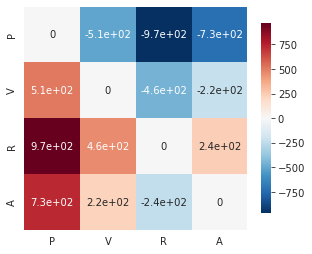

In [168]:
plt.figure(figsize=(5, 5))
sns.heatmap(four_four_matrix, annot=True, square=True, cmap="RdBu_r", center=0, xticklabels=four_four_index, yticklabels=four_four_index, cbar_kws={"shrink": 0.7})
plt.show()

In [ ]:
# seqs_second_aa = [ 'W' + aa + 'P' for aa in all_possible_aa]
#
# save_data_matrix_abs_P, save_data_matrix_normal_P = perturbation_conversion_process_DIY_sequences(2, seqs_P)
# save_data_matrix_abs_V, save_data_matrix_normal_V = perturbation_conversion_process_DIY_sequences(2, seqs_V)
# save_data_matrix_abs_R, save_data_matrix_normal_R = perturbation_conversion_process_DIY_sequences(2, seqs_R)
# save_data_matrix_abs_A, save_data_matrix_normal_A = perturbation_conversion_process_DIY_sequences(2, seqs_A)

# 5.3.2 model experiments part

In [171]:
def perturbation_conversion_process_DIY_sequences_aa():
    sequences = ['WP', 'WV', 'WR', 'WA']
    four_four_model_matrix = [[0 for i in range(4)] for i in range(4)]
    four_model_value = [[] for i in range(4)]
    iter_sequences = sequences

    new_model.eval()

    for k in tqdm(range(len(iter_sequences))):
        for i in range(len(aa_list)):
            iter_sequence_origin = iter_sequences[k] + aa_list[i]
            iter_sequence_len = len(iter_sequence_origin)

            sequence_code_origin = get_one_sequence_code(iter_sequence_origin)
            with torch.no_grad():
                output, feature = new_model(sequence_code_origin)
            output = torch.softmax(output, dim=1)[0][1].item()
            four_model_value[k].append(output)

    for i in range(len(four_model_value)):
        for j in range(len(four_model_value)):
            four_four_model_matrix[i][j] = sum(four_model_value[j])- (sum(four_model_value[i]))
            # four_four_model_matrix[i][j] = sum(four_model_value[j]) - max(four_model_value[j]) - (sum(four_model_value[i]) - max(four_model_value[i]))

    return four_four_model_matrix, four_model_value

In [172]:
four_four_model_matrix, four_model_value = perturbation_conversion_process_DIY_sequences_aa()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


In [173]:
four_four_model_matrix_modified = [[0 for j in range(4)] for i in range(4)]
for i in range(len(four_model_value)):
    for j in range(len(four_model_value)):
        four_four_model_matrix_modified[i][j] = (sum(four_model_value[j]) - sum(four_model_value[i]))/5 + (save_data_matrix_normal_P[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1] + save_data_matrix_normal_V[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1] + save_data_matrix_normal_R[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1] + save_data_matrix_normal_A[aa_dict[four_four_index[i]]-1][aa_dict[four_four_index[j]]-1])

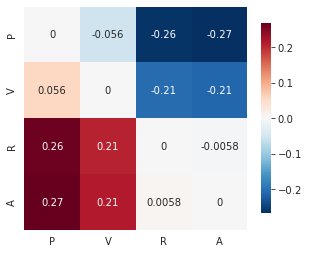

In [175]:
plt.figure(figsize=(5, 5))
sns.heatmap(four_four_model_matrix, annot=True, square=True, cmap="RdBu_r", center=0, xticklabels=four_four_index, yticklabels=four_four_index, cbar_kws={"shrink": 0.7})
plt.show()